# Project: Wrangling and Analyze Data

**Table of Contents**

- [Setting the workspace](#Setting)
- [Data Gathering](#gathering)
- [Assessing Data](#assessing)
- [Cleanning Data](#cleaning)
- [Merge Data](#merge)
- [Store Data](#store)
- [Analyzing and Visualize Data](#analyze)
- [Insights](#insights)

<a id='Setting'></a>
**Setting the workspace**

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import tweepy
import glob
import requests
import os
import seaborn as sns
import json 
import PIL.Image
from io import BytesIO
from PIL import Image
from timeit import Timer
from IPython.display import Image

<a id='gathering'></a>
## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

#### Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
# Open the csv file
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
# Download the image prediction file using the link the link provided
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image_request= requests.get(url, allow_redirects=True)

open('image_predictions.tsv', 'wb').write(image_request.content)

335079

In [4]:
#Read TSV file
image_prediction = pd.read_csv('image_predictions.tsv', sep='\t' )
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt) . Ref: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

In [5]:
# Tweepy keys and token

auth = tweepy.OAuthHandler('','')
auth.set_access_token('','')

api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [6]:
#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in df_archive['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

Rate limit reached. Sleeping for: 734
Rate limit reached. Sleeping for: 739


In [7]:
#Then in this code block we isolate the json part of each tweepy 
#status object that we have downloaded and we add them all into a list
my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)
    
#we write this list into a txt file:
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))
        
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_status = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [17]:
tweet_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 8 columns):
tweet_id            2328 non-null object
favorite_count      2328 non-null int64
retweet_count       2328 non-null int64
followers_count     2328 non-null int64
friends_count       2328 non-null int64
source              2328 non-null object
retweeted_status    2328 non-null object
url                 2328 non-null object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


<a id='assessing'></a>
## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.


#### df_archive

In [18]:
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [19]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [20]:
df_archive.shape

(2356, 17)

In [21]:
#check duplicate data for tweet_id 
df_archive.tweet_id.duplicated().sum()

0

In [22]:
#count the Rating_numerator
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
#count the Rating_denominator. It should be 10, becausa the rating is x/10
len(df_archive[df_archive['rating_denominator']>10])

20

In [24]:
# count number of retweets
df_archive.retweeted_status_user_id.count()

181

In [25]:
# count the names
df_archive['name'].value_counts()

None         745
a             55
Charlie       12
Oliver        11
Cooper        11
Lucy          11
Penny         10
Lola          10
Tucker        10
Bo             9
Winston        9
Sadie          8
the            8
Bailey         7
Buddy          7
an             7
Toby           7
Daisy          7
Jax            6
Stanley        6
Koda           6
Milo           6
Jack           6
Scout          6
Dave           6
Bella          6
Oscar          6
Leo            6
Rusty          6
Gus            5
            ... 
Brady          1
Jennifur       1
Butters        1
Amber          1
Philippe       1
Hanz           1
Peanut         1
Rufio          1
Kody           1
Suki           1
Grizzie        1
Mike           1
Smiley         1
Tuco           1
Daniel         1
Shnuggles      1
Tiger          1
Akumi          1
Carll          1
Yoda           1
Snickers       1
Bruno          1
Taz            1
Crumpet        1
Chaz           1
Barclay        1
Saydee         1
Ruffles       

In [26]:
# The list of values in the 'doggo' column
df_archive.doggo.unique()

array(['None', 'doggo'], dtype=object)

In [27]:
# The list of values in the 'floofer' column
df_archive.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [28]:
# The list of values in the 'pupper' column
df_archive.pupper.unique()

array(['None', 'pupper'], dtype=object)

In [29]:
# The list of values in the 'puppo' column
df_archive.puppo.unique()

array(['None', 'puppo'], dtype=object)

### image_prediction

In [30]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
image_prediction.shape

(2075, 12)

In [32]:
image_prediction.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
719,685906723014619143,https://pbs.twimg.com/media/CYTUhn7WkAEXocW.jpg,1,Yorkshire_terrier,0.414963,True,briard,0.063505,True,Pekinese,0.053682,True
497,675798442703122432,https://pbs.twimg.com/media/CWDrGH4UYAARoq_.jpg,1,beagle,0.681218,True,basset,0.125121,True,boxer,0.080398,True
1134,728653952833728512,https://pbs.twimg.com/media/Chyy5lQWUAEzxSL.jpg,2,window_shade,0.594333,False,studio_couch,0.053515,False,rotisserie,0.041248,False
1845,838921590096166913,https://pbs.twimg.com/media/C6Ryuf7UoAAFX4a.jpg,1,Border_terrier,0.664538,True,Brabancon_griffon,0.170451,True,Yorkshire_terrier,0.087824,True
1340,758740312047005698,https://pbs.twimg.com/media/CoeWSJcUIAAv3Bq.jpg,1,Chesapeake_Bay_retriever,0.848514,True,Labrador_retriever,0.110054,True,curly-coated_retriever,0.025201,True


In [33]:
# Let´s see a image form the tweet_id=1845
Image(url = 'https://pbs.twimg.com/media/C6Ryuf7UoAAFX4a.jpg')

In [34]:
#Let's see how many duplicated Tweets are in the list.
image_prediction.tweet_id.duplicated().sum()

0

In [35]:
#How many duplicate value for the "jpg_url" are duplicated
image_prediction.jpg_url.duplicated().sum()

66

In [36]:
#Count the number of the first predictions per type of dog
image_prediction['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
Cardigan                      19
web_site                      19
beagle                        18
Shetland_sheepdog             18
teddy                         18
Eskimo_dog                    18
Maltese_dog                   18
Lakeland_terrier              17
Shih-Tzu                      17
Rottweiler                    17
kuvasz                        16
Italian_greyhound             16
          

In [37]:
#Count the number of the second predictions per type of dog
image_prediction['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
miniature_poodle                   33
Siberian_husky                     33
beagle                             28
collie                             27
Pembroke                           27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
Pekinese                           21
American_Staffordshire_terrier     21
malinois                           20
miniature_pinscher                 20
toy_terrier                        20
chow                               20
Samoyed                            20
Norwegian_elkhound                 19
Boston_bull                        19
Staffordshir

In [38]:
#Count the number of the third predictions per type of dog
image_prediction['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pomeranian                        29
Pekinese                          29
toy_poodle                        29
Chesapeake_Bay_retriever          27
Great_Pyrenees                    27
Pembroke                          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
toy_terrier                       20
bull_mastiff                      20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
d

In [39]:
# How may first  predications "p1_dog" are actually dogs
image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [40]:
# How Many second predications "p2_dog" are not dogs
(image_prediction.p2_dog==False).sum()

522

In [41]:
# How Many third predications "p3_dog" are not dogs
(image_prediction.p3_dog==False).sum()

576

In [42]:
#Number of null value in the image predictions
image_prediction.img_num.isnull().sum()

0

### tweet_status

In [43]:
#some columns that weren't so useful were drop
tweet_status.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,34483,7168,9056572,20,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,29896,5390,9056572,20,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,22505,3552,9056572,20,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,37719,7393,9056572,20,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36021,7927,9056572,20,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [44]:
tweet_status.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 8 columns):
tweet_id            2328 non-null object
favorite_count      2328 non-null int64
retweet_count       2328 non-null int64
followers_count     2328 non-null int64
friends_count       2328 non-null int64
source              2328 non-null object
retweeted_status    2328 non-null object
url                 2328 non-null object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


In [45]:
tweet_status.shape

(2328, 8)

In [46]:
tweet_status.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2328.000000,2328.000000,2.328000e+03,2328.0
mean,7198.637027,2530.752148,9.056579e+06,20.0
std,11182.944651,4284.769014,3.346489e+01,0.0
min,0.000000,1.000000,9.056561e+06,20.0
25%,1249.000000,510.750000,9.056572e+06,20.0
50%,3114.000000,1178.500000,9.056576e+06,20.0
75%,8793.500000,2925.000000,9.056588e+06,20.0
max,147874.000000,72527.000000,9.056989e+06,20.0


In [47]:
tweet_status.nunique()

tweet_id            2328
favorite_count      1985
retweet_count       1676
followers_count       18
friends_count          1
source                 4
retweeted_status       2
url                 2132
dtype: int64

### Quality issues

**df_archive**

1. The 'timestamap' column is a string it can be changed to a date format

2. There are 20 rows with denominators different than 10.

3. The retweets can duplicate information

4. There are 55 'names' == a. This is a odd name.

**image_prediction**

5. The column names such as p1,p2 are not descriptive.

6. Duplicated values in the image_prediction_clean

7. Dog names format should be consistent. 

**tweet_status**
8. Remove the retweets




### Tidiness issues
1. Transform the 'None' to empty cells of [doggo,floofer,pupper,puppo] and then unify in a 'dog class' column
2. The information of the tweets is located in the three tables.

<a id='cleaning'></a>
## Cleaning Data

- [Unify the columns of Dog Classification](#dogclass)
- ['timestamap' to a date format](#timestamp)
- [Remove retweets](#retweet)
- [Denominators should be 10](#denominator)
- [Change the name of p1, p2, p3](#pa)
- [Duplicated information in Df_archive](#duplicated1)
- [Dog breeds format ](#dog)
- [Duplicated values in image_prediction_clean](#duplicated2)

In [152]:
# Copies of original pieces of data

df_archive_clean=df_archive.copy()
image_prediction_clean=image_prediction.copy()
tweet_status_clean=tweet_status.copy()


<a id='dogclass'></a>
### Issue #1: Unify the columns of Dog Classification

#### Define:
- We can use the for loop to replace all the 'None' to Null in the columns ['doggo','pupper', 'floofer', 'puppo' ] of the df_archive_clean

#### Code

In [153]:
#Loop to change the None to null
dog_c = ['doggo','pupper', 'floofer', 'puppo' ]
for i in dog_c:
       df_archive_clean[i] = df_archive_clean[i].replace('None', '')

In [154]:
# combine the dog_c ['doggo','pupper', 'floofer', 'puppo' ] into one column call dog_class
df_archive_clean['dog_class'] = df_archive_clean.doggo.str.cat(df_archive_clean.floofer).str.cat(df_archive_clean.pupper).str.cat(df_archive_clean.puppo)

# drop the four old colomns
df_archive_clean = df_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis = 1)

# use np.nan to fill the empty
df_archive_clean['dog_class'] = df_archive_clean['dog_class'].replace('', np.nan)

#### Test

In [155]:
#check sample data to confirm create dog_class, replace Npne with Nan and drop another columns 
df_archive_clean.dog_class.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggopuppo',
       'doggofloofer', 'doggopupper'], dtype=object)

In [156]:
len(df_archive_clean[df_archive_clean['dog_class']=='doggopuppo'])

1

In [157]:
len(df_archive_clean[df_archive_clean['dog_class']=='doggofloofer'])

1

In [158]:
len(df_archive_clean[df_archive_clean['dog_class']=='doggopupper'])

12

In [159]:
#code
#As the teacher required ---> Use the follow: df_1_clean.loc[df_1_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
df_archive_clean.loc[df_archive_clean.dog_class == 'doggopupper', 'dog_class'] = 'doggo, pupper'
df_archive_clean.loc[df_archive_clean.dog_class == 'doggopuppo', 'dog_class'] = 'doggo, puppo'
df_archive_clean.loc[df_archive_clean.dog_class == 'doggofloofer', 'dog_class'] = 'doggo, floofer'

In [160]:
#Test
#check sample data to confirm create dog_class
df_archive_clean.dog_class.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

<a id='timestamp'></a>
### Issue #2: 'timestamap' to a date format

#### Define

Create columns day, month and year
Delete the column 'timestamp'

#### Code

In [161]:
#convert timestamp to datetime
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean['timestamp'])

#extract year, month and day to new columns
df_archive_clean['year'] = df_archive_clean['timestamp'].dt.year
df_archive_clean['month'] = df_archive_clean['timestamp'].dt.month
df_archive_clean['weekday'] = df_archive_clean['timestamp'].dt.day_name()

In [162]:
# drop timestamp column
df_archive_clean = df_archive_clean.drop('timestamp', 1)

#### Test

In [163]:
 #check the new columns

df_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_class,year,month,weekday
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,2017,8,Tuesday
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,2017,8,Tuesday
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,2017,7,Monday
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,2017,7,Sunday
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,2017,7,Saturday


<a id='retweet'></a>
### Issue #3: Remove the retweets

In [164]:
#Define: Delete the retweets

In [165]:
#Code
# exclude all the retweets by filtterate it
df_archive_clean=df_archive_clean[df_archive_clean['retweeted_status_user_id'].isnull()]

In [166]:
#Test
#check retweeted_status_user_id have any retweet
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
dog_class                     344 non-null object
year                          2175 non-null int64
month                         2175 non-null int64
weekday                       2175 non-null object
dtypes: float64(4), int64(5), object(7)
memory usage: 288.9+ KB


<a id='denominator'></a>
### Issue #4: Denominator should be 10

#### Define:
The Denominator should be 10, however this column is not going to be used. So I will drop it.

####  Delete the columns that won't be used

#### Define:
Drop the columns ['retweeted_status_id','in_reply_to_status_id','in_reply_to_user_id'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls','source','rating_denominator']

In [167]:
#code
#drop unwanted columns 
df_archive_clean=df_archive_clean.drop(['retweeted_status_id','in_reply_to_status_id','in_reply_to_user_id',
 'retweeted_status_user_id', 'retweeted_status_timestamp','expanded_urls','source','rating_denominator'], axis = 1)

In [168]:
#test
#confirm deleted columns 
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id            2175 non-null int64
text                2175 non-null object
rating_numerator    2175 non-null int64
name                2175 non-null object
dog_class           344 non-null object
year                2175 non-null int64
month               2175 non-null int64
weekday             2175 non-null object
dtypes: int64(4), object(4)
memory usage: 152.9+ KB


<a id='pa'></a>
### Issue #5: The of the columns P1, P2, P3, P1_conf, P2_conf, P3_conf no are very descriptive

#### Define
Change the names of the columns P1, P2, P3, P1_conf, P2_conf, P3_conf

In [169]:
#code
#Rename the columns
image_prediction_clean=image_prediction_clean.rename(columns={'p1':'first_prediction', 'p1_conf': 'first_confidence', 'p1_dog': 'first_dog',
                                  'p2': 'second_prediction', 'p2_conf': 'second_confidence', 'p2_dog': 'second_dog',
                                  'p3': 'third_prediction', 'p3_conf': 'third_confidence', 'p3_dog': 'third_dog'})

In [170]:
#test
#List of the column names
list(image_prediction_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'first_prediction',
 'first_confidence',
 'first_dog',
 'second_prediction',
 'second_confidence',
 'second_dog',
 'third_prediction',
 'third_confidence',
 'third_dog']

<a id='duplicated'></a>
### Issue #6: Duplicated values in the image_prediction_clean

#### Define
Delete the duplicated values in the image_prediction_clean

In [171]:
#Code
#drop duplicate value
image_prediction_clean=image_prediction_clean.drop_duplicates(subset=['jpg_url'], keep='first')

In [172]:
#test
# count the duplicates in the jpg_url column
image_prediction_clean.jpg_url.duplicated().sum()

0

<a id='dog'></a>
### Issue #7: the names of the dogs don't have the same format

#### Define
Homogenize the format of the predictions of the dogs to a uppercase for the first letter.

In [173]:
#Code 
#Capitalize first letter by using Capitalize method
image_prediction_clean.first_prediction=image_prediction_clean.first_prediction.str.capitalize()
image_prediction_clean.second_prediction=image_prediction_clean.second_prediction.str.capitalize()
image_prediction_clean.third_prediction=image_prediction_clean.third_prediction.str.capitalize()

In [174]:
#test
#see the list of the second_prediction
image_prediction_clean['second_prediction'].value_counts()

Labrador_retriever                96
Golden_retriever                  83
Cardigan                          73
Chihuahua                         43
French_bulldog                    40
Chesapeake_bay_retriever          40
Pomeranian                        39
Toy_poodle                        36
Siberian_husky                    33
Miniature_poodle                  32
Cocker_spaniel                    32
Beagle                            28
Eskimo_dog                        27
Collie                            26
Pembroke                          25
Kuvasz                            25
Italian_greyhound                 22
Pekinese                          21
Chow                              20
American_staffordshire_terrier    20
Miniature_pinscher                20
Malinois                          20
Toy_terrier                       19
Norwegian_elkhound                19
Samoyed                           19
Boston_bull                       19
Staffordshire_bullterrier         18
P

<a id='duplicated2'></a>
### Issue #8: Delete the retweets

#### Define
Delete the retweets

In [175]:
tweet_status_clean.retweeted_status.unique()

array(['Original tweet', 'This is a retweet'], dtype=object)

In [176]:
#Code
#drop the 'This is a retweet'

tweet_status_clean=tweet_status_clean.loc[tweet_status_clean['retweeted_status']=='Original tweet']

In [177]:
#Test: there should be just 'Original tweet'
tweet_status_clean.retweeted_status.unique()

array(['Original tweet'], dtype=object)

In [178]:
#verify wee have usefull columns
tweet_status_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2327
Data columns (total 8 columns):
tweet_id            2167 non-null object
favorite_count      2167 non-null int64
retweet_count       2167 non-null int64
followers_count     2167 non-null int64
friends_count       2167 non-null int64
source              2167 non-null object
retweeted_status    2167 non-null object
url                 2167 non-null object
dtypes: int64(4), object(4)
memory usage: 152.4+ KB


In [179]:
tweet_status_clean['tweet_id'] = tweet_status_clean['tweet_id'].astype(int)

In [180]:
df_archive_clean['tweet_id']

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
5       891087950875897856
6       890971913173991426
7       890729181411237888
8       890609185150312448
9       890240255349198849
10      890006608113172480
11      889880896479866881
12      889665388333682689
13      889638837579907072
14      889531135344209921
15      889278841981685760
16      888917238123831296
17      888804989199671297
18      888554962724278272
20      888078434458587136
21      887705289381826560
22      887517139158093824
23      887473957103951883
24      887343217045368832
25      887101392804085760
26      886983233522544640
27      886736880519319552
28      886680336477933568
29      886366144734445568
30      886267009285017600
               ...        
2326    666411507551481857
2327    666407126856765440
2328    666396247373291520
2329    666373753744588802
2330    666362758909284353
2331    666353288456101888
2

<a id='merge'></a>
## Merge Data

Merge data from df_archive_clean, image_prediction_clean, tweet_status_clean to a unique table.

In [182]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id            2175 non-null int64
text                2175 non-null object
rating_numerator    2175 non-null int64
name                2175 non-null object
dog_class           344 non-null object
year                2175 non-null int64
month               2175 non-null int64
weekday             2175 non-null object
dtypes: int64(4), object(4)
memory usage: 152.9+ KB


In [183]:
#Merge tweets_archive data with the image_preddiction
archive_preddiction=pd.merge(df_archive_clean, tweet_status_clean, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [184]:
archive_preddiction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 15 columns):
tweet_id            2167 non-null int64
text                2167 non-null object
rating_numerator    2167 non-null int64
name                2167 non-null object
dog_class           343 non-null object
year                2167 non-null int64
month               2167 non-null int64
weekday             2167 non-null object
favorite_count      2167 non-null int64
retweet_count       2167 non-null int64
followers_count     2167 non-null int64
friends_count       2167 non-null int64
source              2167 non-null object
retweeted_status    2167 non-null object
url                 2167 non-null object
dtypes: int64(8), object(7)
memory usage: 270.9+ KB


In [185]:
#Merge tweets_archive data with the image_preddiction
df_merge=pd.merge(archive_preddiction, image_prediction_clean, how='inner', on=None, left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)

In [186]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 26 columns):
tweet_id             1986 non-null int64
text                 1986 non-null object
rating_numerator     1986 non-null int64
name                 1986 non-null object
dog_class            305 non-null object
year                 1986 non-null int64
month                1986 non-null int64
weekday              1986 non-null object
favorite_count       1986 non-null int64
retweet_count        1986 non-null int64
followers_count      1986 non-null int64
friends_count        1986 non-null int64
source               1986 non-null object
retweeted_status     1986 non-null object
url                  1986 non-null object
jpg_url              1986 non-null object
img_num              1986 non-null int64
first_prediction     1986 non-null object
first_confidence     1986 non-null float64
first_dog            1986 non-null bool
second_prediction    1986 non-null object
second_confidence    1

<a id='store'></a>
## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [187]:
#Sort values
df_merge.sort_values(by=['year','month','weekday'])

,tweet_id,text,rating_numerator,name,dog_class,year,month,weekday,favorite_count,retweet_count,...,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
83,667495797102141441,This is Philippe from Soviet Russia. Commandin...,9,Philippe,NaN,2015,11,Friday,470,236,...,1,Chihuahua,0.143957,True,Christmas_stocking,0.118651,False,Ski_mask,0.092482,False
84,667502640335572993,Say hello to Hall and Oates. Oates is winking ...,11,Hall,NaN,2015,11,Friday,494,198,...,1,Labrador_retriever,0.996709,True,Golden_retriever,0.001688,True,Beagle,0.000712,True
85,667509364010450944,This a Norwegian Pewterschmidt named Tickles. ...,12,None,NaN,2015,11,Friday,6201,1901,...,1,Beagle,0.636169,True,Labrador_retriever,0.119256,True,Golden_retriever,0.082549,True
86,667517642048163840,This is Dook &amp; Milo. Dook is struggling to...,8,Dook,NaN,2015,11,Friday,338,172,...,1,Italian_greyhound,0.125176,True,Standard_poodle,0.084572,True,Cocker_spaniel,0.081347,True
87,667524857454854144,Another topnotch dog. His name is Big Jumpy Ra...,12,None,NaN,2015,11,Friday,1536,998,...,1,Hare,0.447893,False,Dhole,0.092435,False,Chesapeake_bay_retriever,0.088122,True
88,667530908589760512,Meet Naphaniel. He doesn't necessarily enjoy h...,10,Naphaniel,NaN,2015,11,Friday,423,215,...,1,Golden_retriever,0.633037,True,Kuvasz,0.146391,True,Labrador_retriever,0.046184,True
89,667534815156183040,"This is Frank (pronounced ""Fronq""). Too many b...",8,Frank,NaN,2015,11,Friday,734,466,...,1,Pembroke,0.435254,True,Cardigan,0.307407,True,Cocker_spaniel,0.033158,True
90,667538891197542400,This is a southwest Coriander named Klint. Hat...,9,a,NaN,2015,11,Friday,183,59,...,1,Yorkshire_terrier,0.618957,True,Silky_terrier,0.300313,True,Australian_terrier,0.053412,True
91,667544320556335104,"This is Kial. Kial is either wearing a cape, w...",10,Kial,NaN,2015,11,Friday,779,476,...,1,Pomeranian,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True
92,667546741521195010,Here is George. George took a selfie of his ne...,9,George,NaN,2015,11,Friday,309,112,...,1,Toy_poodle,0.787424,True,Miniature_poodle,0.202225,True,Teddy,0.004047,False


In [188]:
# save and store new data in csv
df_merge.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

<a id='analyze'></a>
## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [189]:
df_clean=pd.read_csv('twitter_archive_master.csv')

In [190]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 26 columns):
tweet_id             1986 non-null int64
text                 1986 non-null object
rating_numerator     1986 non-null int64
name                 1986 non-null object
dog_class            305 non-null object
year                 1986 non-null int64
month                1986 non-null int64
weekday              1986 non-null object
favorite_count       1986 non-null int64
retweet_count        1986 non-null int64
followers_count      1986 non-null int64
friends_count        1986 non-null int64
source               1986 non-null object
retweeted_status     1986 non-null object
url                  1986 non-null object
jpg_url              1986 non-null object
img_num              1986 non-null int64
first_prediction     1986 non-null object
first_confidence     1986 non-null float64
first_dog            1986 non-null bool
second_prediction    1986 non-null object
second_confidence    1

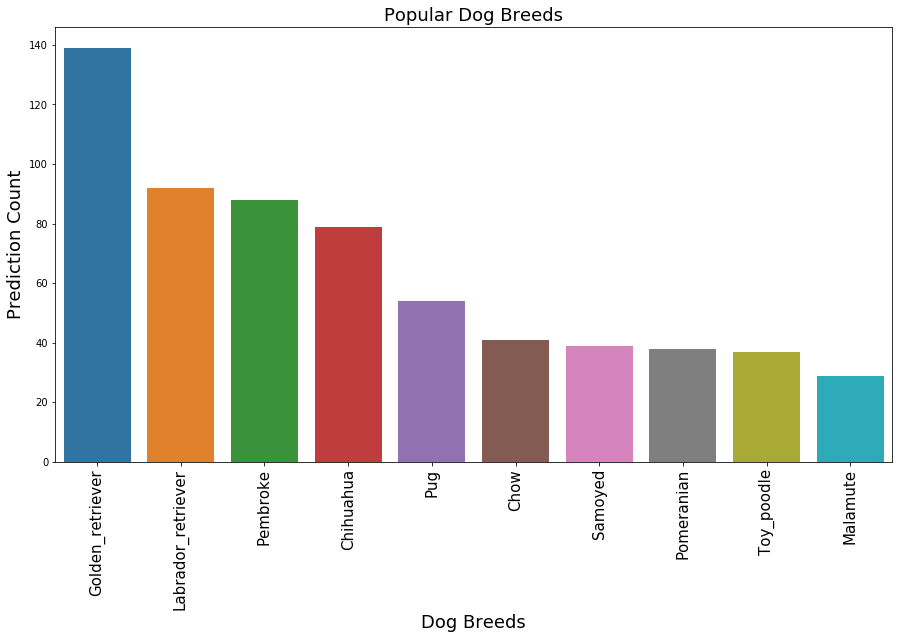

In [191]:
# Show the most commun Dog Breeds

plt.figure(figsize = (15,8))
ax = sns.barplot(x = df_clean['first_prediction'].value_counts()[0:10].index,
            y =df_clean['first_prediction'].value_counts()[0:10],
            data = df_clean);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);
plt.xlabel("Dog Breeds",fontsize = 18);
plt.ylabel("Prediction Count",fontsize = 18);
plt.title("Popular Dog Breeds",fontsize = 18);

The most common dog breeds are Golden_retriever, Labrador_retriever and Pembrok.

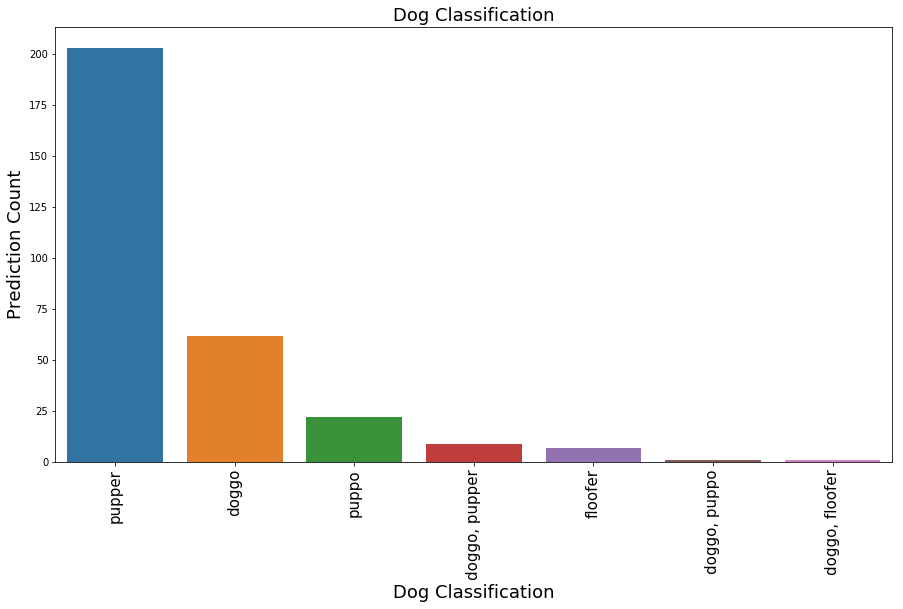

In [192]:
# Show the most commun Dog Class

plt.figure(figsize = (15,8))
ax = sns.barplot(x = df_clean['dog_class'].value_counts()[0:10].index,
            y =df_clean['dog_class'].value_counts()[0:10],
            data = df_clean);
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize = 15);
plt.xlabel("Dog Classification",fontsize = 18);
plt.ylabel("Prediction Count",fontsize = 18);
plt.title("Dog Classification",fontsize = 18);



There are 14 tweets_id with 2 dog classification, I must erase it from the database, but I Keep it.

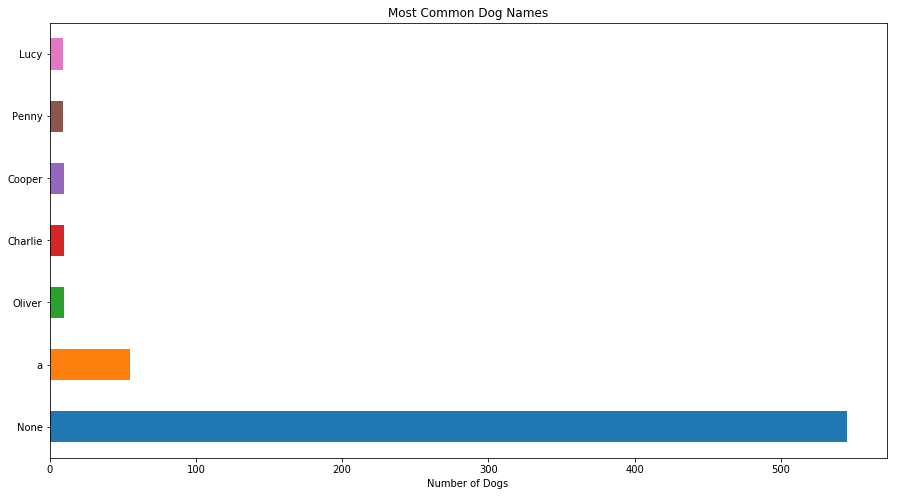

In [204]:
# The most common names for dogs
df_clean.name.value_counts()[0:7].plot('barh', figsize=(15,8), title='Most Common Dog Names').set_xlabel("Number of Dogs");




The dogs with names a and none. This can be erase too.

The most common names are Oliver, Cooper, Charlie, Tucker and Penny.

We can see some pictures of Golden Retrievers

In [194]:
#get data frame for  golden_retriever
golden_df = df_clean.query('first_prediction == "Golden_retriever"')

In [195]:
golden_df.sample(3)

,tweet_id,text,rating_numerator,name,dog_class,year,month,weekday,favorite_count,retweet_count,...,img_num,first_prediction,first_confidence,first_dog,second_prediction,second_confidence,second_dog,third_prediction,third_confidence,third_dog
1208,743210557239623680,"Meet Kayla, an underground poker legend. Playe...",10,Kayla,NaN,2016,6,Wednesday,3633,1273,...,1,Golden_retriever,0.930705,True,Chesapeake_bay_retriever,0.025934,True,Labrador_retriever,0.007535,True
163,668979806671884288,This is Chaz. He's an X Games half pipe supers...,12,Chaz,NaN,2015,11,Tuesday,723,305,...,1,Golden_retriever,0.608537,True,Irish_setter,0.097078,True,Redbone,0.076022,True
155,668852170888998912,Say hello to Bobb. Bobb is a Golden High Fescu...,11,Bobb,NaN,2015,11,Monday,415,145,...,1,Golden_retriever,0.903529,True,Tibetan_mastiff,0.041497,True,Kuvasz,0.022500,True


In [197]:
url1 = df_clean.jpg_url[1208]
Image(url=url1)

In [198]:
url2 = df_clean.jpg_url[163]
Image(url=url2)

In [199]:
url3 = df_clean.jpg_url[155]
Image(url=url3)

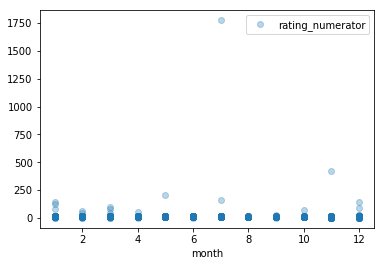

In [200]:
# rating per month count 

df_clean.plot(y='rating_numerator',x='month',style='o',alpha=.3);

We can see some rating_numerator outliers

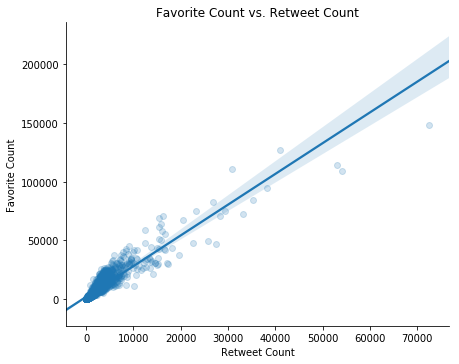

In [201]:
#Scatterplot of retweets vs favorite count

sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=df_clean,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5});

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

<a id='insights'></a>
### Insights:
1. The most common names are Oliver, Cooper, Charlie, Tucker and Penny.

2. The most common classification is Pupper

3. The retweet count has a possitive correlation with the favorite count